# Recurrent Neural Network for Text Generation

This tutorial is about Natural Language Processing (NLP) with Recurrent Neural Networks (RNN). We will use an RNN to build a (generative) language model that can produce new text snippets of similar style as in the training corpus. Unfortunately, NLP projects always involve a lot of data preprocessing. RNN based models are successful for rather short text snippets. The more recent technique of transformer networks show much better performance and scale to much longer texts (e.g. BERT or GPT-2). But they would also need much more computational resources for training, of course, which is why we content ourselves with this rather simple RNN model.

**Information:**
> If you run into any problems regarding insufficient computing power or RAM, you can skip the training part and jump straight to the generation. Or, if you are interested, limit the dataset and try the training again.

## Dating for Nerds

Nerds are notoriously bad when it comes to dating. Therefore, we aim to provide a new service to these shy and hesitant people that suggest pickup lines. Deployed as a mobile app, our customers hopefully get good support in finding the love of their life. We already crawled a dataset of $18150$, hopefully, successful pickup lines from the internet. So, let us start developing the world's first MACHO BOT ...

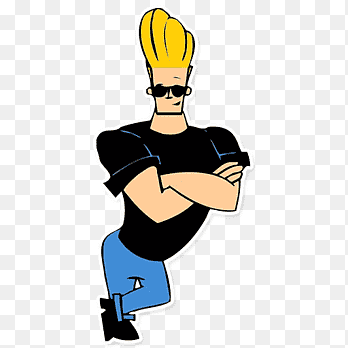

Image: Johnny Bravo

**Disclaimer:** 

> Some of the crawled pickup lines are vulgar and offensive. But we chose this example intentionally and will reflect on this at the end of the notebook.

In [ ]:
import pickle
import gzip
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os.path

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import load_model

# Library for Fracebook word embeddings
# pip install --upgrade fasttext
import fasttext.util

# Library for progress bars
# pip install --upgrade tqdm
from tqdm.auto import tqdm

# Interactive elements for Jupyter notebooks
from ipywidgets import interact

# Make sure you have the right tensorflow version installed
assert tf.__version__ >= "2.1.0"

### Graphic Processing Unit (GPU)

You can run the notebook without any additional computing resources. However, it will take much longer to train the network. Therefore we recommend to go through the code and skip the training of the network. But if you have access to some additional computing resources, such as a GPU, you can certainly train the network and try to make adjustments to it. You can run the next cell to make sure TensorFlow correctly initializes the GPU. If no GPU is found, there will not be any output.

In [ ]:
gpus = tf.config.experimental.list_physical_devices("GPU")

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Download pre-trained `fasttext` word embeddings for English. This can take up to one hour depending on your network speed. The downloaded model is almost 4GB large and will be stored on your harddisc. Our code skips the download if the file is already avaiable. 

In [ ]:
fasttext.util.download_model("en", if_exists="ignore")

## Data Loading and Examination

Load the crawled pickup lines dataset into a pandas dataframe. The dataset consists of four columns:
* `text`: the pickup line
* `url`: the origin of the pickup line
* `text_len`: the number of characters of the pickup line
* `text_word_count`: the number of words of the pickup line

In [ ]:
df = pd.read_csv("pickup_lines_dataset_cleaned.csv", index_col=0, encoding="utf-8")
df.head()

Let us look at some stats of the dataset, starting with the distribution of the text length. We can see that most pickup lines are in the range between 30-90.

In [ ]:
df.hist(column=["text_len"], bins=100)
plt.title("Distribution of text length")
plt.xlabel("text length")
plt.ylabel("count in ds")
plt.xlim([0, 400])
plt.show()

Furthermore, the next cell shows that most pickup lines contain between 7-16 words. This seems like a typical length of pickup lines to be generated. 

In [ ]:
df.hist(column=["text_word_count"], bins=100)
plt.title("Distribution of word counts")
plt.xlim([0, 60])
plt.show()

## Data Preprocessing

After examining the data, we must take care of ponctuation.

In [ ]:
# Extract only the text (pickup lines) from the dataframe
text = df["text"]

# Replace some punctation
text = text.str.replace(";", ",")
text = text.str.replace("...", ".", regex=False)
text = text.str.replace("…", ".", regex=False)
text.head(n=3).tolist()

In [ ]:
# Symbols we want to filter out
unwanted_punctation = r"'„“#$%&()*+-/:<=>@[\]^_`{|}~"
# Symbols we want to keep
wanted_punctation = r",?!."

# Add whitespace before wanted punctation
for punctation in wanted_punctation:
    text = text.str.replace(punctation, " {}".format(punctation))
text.head(n=3).tolist()

Before training, we need to map strings to a numerical representation. Create two lookup tables: one mapping characters to numbers (`word_index`), and another for numbers to characters (`rev_index`).

In [ ]:
tokenizer = Tokenizer(filters=unwanted_punctation, lower=False)
tokenizer.fit_on_texts(text.to_list())

# dict: keys=word, value=index in bag-of-words
word_index = tokenizer.word_index

# dict: keys=index in bag-of-words, value=word (used to turn bag-of-words into text)
rev_index = {v:k for k,v in word_index.items()}

# Print some dictionary entries for illustration
for char,_ in zip(word_index, range(7)):
    print("  {} -> {},".format(repr(char), word_index[char]), end='')
print(' ...')

As an example, we will now map a sentence to a numerical representation. Consider the sentence *Do you want to go out with me?*.

In [ ]:
sent = "Do you want to go out with me?"
sent_num = encoded = tokenizer.texts_to_sequences([sent])[0]
print("Sentence '{}' mapped to '{}'".format(sent, sent_num))

Load embeddings from ``fasttext`` file and create embeddings matrix. The number of rows equals the number of words in the corpus (plus 1 for an out-of-vocabulary (OOV) token), the number of columns equals the dimension of the embedding vectors, i.e. $300$ in case of fasttext. Again, loading 4GB into memory can take a while.

In [ ]:
ft = fasttext.load_model("cc.en.300.bin")

In [ ]:
EMBEDDING_DIM = 300
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word in word_index.keys():
    word_idx = word_index[word]
    word_vec = ft.get_word_vector(word)
    # Add word vec to the embedding matrix at the index of the word
    embedding_matrix[word_idx] = word_vec
    
print('Embeddings matrix shape:', embedding_matrix.shape)

Given a word, or a sequence of words, what is the most probable next word? This is the task we are going to train the model for. The input to the model will thus be a sequence of words, and we train the model to predict the output, the following word at each time step. To do this, we first create sequences of $n$ consecutive words, the first $n-1$ being the input and the last being the output (what the model will learn to predict).

In [ ]:
# We generate sequences of length 3, i.e. predict the third work from the two foregoing words
SEQUENCE_LEN = 3

sequences = []
for line in text.tolist():
    encoded = tokenizer.texts_to_sequences([line])[0]
    for i in range(SEQUENCE_LEN, len(encoded)+1):
        sequence = encoded[i-SEQUENCE_LEN:i]
        sequences.append(sequence)

# Padding is only necessary if we have lines shorter than SEQUENCE_LEN (not the case here)
sequences = np.array(pad_sequences(sequences, maxlen=SEQUENCE_LEN, padding="pre"))
print('There are {} sequences of length {} words'.format(sequences.shape[0], sequences.shape[1]))

Create dataset consisting of the first two word as input $X$ and the last (third) word as categorical output $y$.

In [ ]:
X = sequences[:,:-1]
y = sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
print("Input shape: {0}, Output shape: {1}".format(X.shape, y.shape))

## RNN Models
Now we define a function that takes the model, a trained tokenizer, a seed word (starting word of the pickup line) and a maximum number of words. The function then generates a sequence of words that follow the learned distribution.

In [ ]:
def generate_seq(model, tokenizer, max_length, seed_text, max_words):
    result = seed_text
    sentence_num = 0
    for _ in range(max_words):
        # Encode the text as integer and pad the sequence to the max length of the sequence
        encoded = tokenizer.texts_to_sequences([result])[0]
        encoded = pad_sequences([encoded], maxlen=max_length, padding="pre")
        
        # Predict probabilities of all next words
        y_probas = model.predict(encoded, batch_size=1024, verbose=0)[0]
        # Get the corresponding classes (the actual words)
        y_classes = np.arange(vocab_size)
        # Sample the next word from the learned distribution
        y_hat = np.random.choice(y_classes, p=y_probas)
        
        # Map predicted word index to word
        out_word = rev_index[y_hat]
        # Append newly sampled word to previous ones
        result += " " + out_word
        
        # Check if sentence end and stop after two sentences
        if out_word in [".", "?", "!"]:
            sentence_num += 1
            if sentence_num == 2:
                break
                
    # Remove whitespace before wanted punctation
    for punctation in wanted_punctation:
        result = result.replace(" {}".format(punctation), punctation)

    return result

A list of all the first words for seeding the generator, sampled from all of the possible words in the dataset.

In [ ]:
seed_words = text.str.capitalize().str.split(" ").map(lambda x: x[0])
print(seed_words[:5])

We create a generator callback which is called after every epoch during training. This callback is supposed to generate a new sequence starting with a randomly sampled word from our `seed_words`. With this output, we can examine the learning behaviour of our model. It should start off with mostly random pickup lines and then briefly start to learn how to build realistic sequences.

In [ ]:
def gen_and_print(epoch, logs):
    seed_word = np.random.choice(seed_words)
    generated = generate_seq(model, tokenizer, SEQUENCE_LEN-1, seed_word, 15)
    print("Epoch {} - {}\n".format(epoch + 1, generated))
    
generator_callback = LambdaCallback(on_epoch_end=gen_and_print)

Next we build the RNN model with LSTM cells.

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 
                    EMBEDDING_DIM, 
                    weights=[embedding_matrix], 
                    input_length=SEQUENCE_LEN-1, 
                    trainable=False))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(vocab_size, activation="softmax"))
model.summary()

Since we now have all the necessary building blocks, we can now compile and train the model using the created dataset $X$ and $y$. $X$ are two words which will be passed to the model, and it will learn to predict the third word $y$. When training the model using `fit()` we will pass it our custom `generator_callback`, which will generate a sequence after each epoch. This step will take some time, depending on the available hardware.

In [ ]:
# Reduce the number of epochs when necessary. 
# Epochs = 200 gives reasonable performance; epochs = 3 is good for testing.

model.compile(loss="categorical_crossentropy", optimizer="adam")
history = model.fit(X, y, epochs=3, verbose=2, callbacks=[generator_callback])

Save the model and tokenizer. Always make sure you also save the tokenizer, otherwise your model would be useless since you can not translate the numerical outputs back into words.

In [ ]:
if not os.path.isfile("model.h5"):
    print("Saved model does not exist, saving current model.")
    model.save("model.h5")
    with open("tokenizer.pkl", "bw") as f:
        pickle.dump(file=f, obj=tokenizer)
else:
    print("Saved model exists, loading it.")
    model = load_model('model.h5')
    with open('tokenizer.pkl', 'br') as f:
        tokenizer = pickle.load(f)

## Use the trained Generator

In the last step, we will use the trained model from above, or the saved model, to generate pickup lines. To do this, we can use the `generate_seq()` function again. You can play around with different seed words and sequence lengths. Maybe you should also retrain the model over night with more epochs. The runtime is fairly linear. Measure the time it takes for 3 epochs and calculate the expected waiting time for e.g. 200 epochs. Have fun.

In [ ]:
generate_seq(model, tokenizer, SEQUENCE_LEN-1, "I", 15)

The generated pick up lines are pretty bad from a grammatical point of view (of course, also when considering the content). Most of them also do not make much sense, which can also be caused by the fact, that pickup lines mostly also don't make much sense :)

## On a more serious Note

You may have heard about Aweful AI - here is a [website](https://github.com/daviddao/awful-ai) that collects all these stories of artificial intelligences turning mad. There are hundrets of such stories: the Microsoft chat bot became racists and antisemitic, the Google image captioning system maks black people as gorillas, the Amazon hiring application filters out women, etc. Why does this happen? Neural networks learn structures from data. When your data is as bad as our pickup lines dataset, then what else can you expect. This sounds like a problem easy to avoid - just make sure that the dataset is appropriate. Oh well, modern deep learning systems are trained on hundred of millions of images and text documents. Who on earth is going to check whether this data does not disadvantage minorities, etc. Training a real conversational agent (not the scriped chatbots from your e-banking system) requires a hell lot of data, and we cannot just use wikipedia for training as a chatbot requires conversational data in question-answer form. the is actually only one data source that is large enough for this: subscripted Hollywood movies. And what shall we expect when we train a neural net on *Hasta la vista, baby* ...